![](img/logo.png)

# Logistic regression
## Yoav Ram

In [58]:
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', DeprecationWarning)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn.datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

# Recognizing handwritten digits 

Learning to recognize handwritten digits with a K-nearest neighbors classifier, inspired by [IPython Interactive Computing and Visualization Cookbook](http://ipython-books.github.io/).

Start by looking at the data.

What do we have here?

In [6]:
X, y = sklearn.datasets.load_digits(return_X_y=True)
X.shape, y.shape

((1797, 64), (1797,))

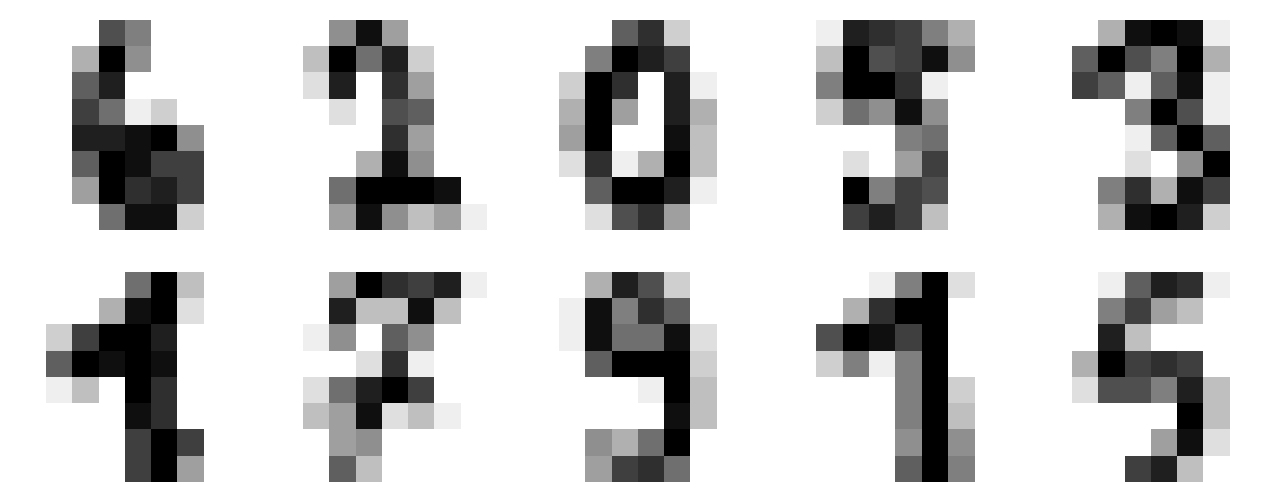

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for ax in axes.flat:
    idx = np.random.choice(np.arange(X.shape[0]))
    ax.matshow(X[idx].reshape(8, 8), cmap='gray_r')
    ax.set(xticks=[], yticks=[])
sns.despine(left=True, bottom=True)

We can also look at the average image for each class, this should tell us if there is enonugh signal in the data to be learned from. 

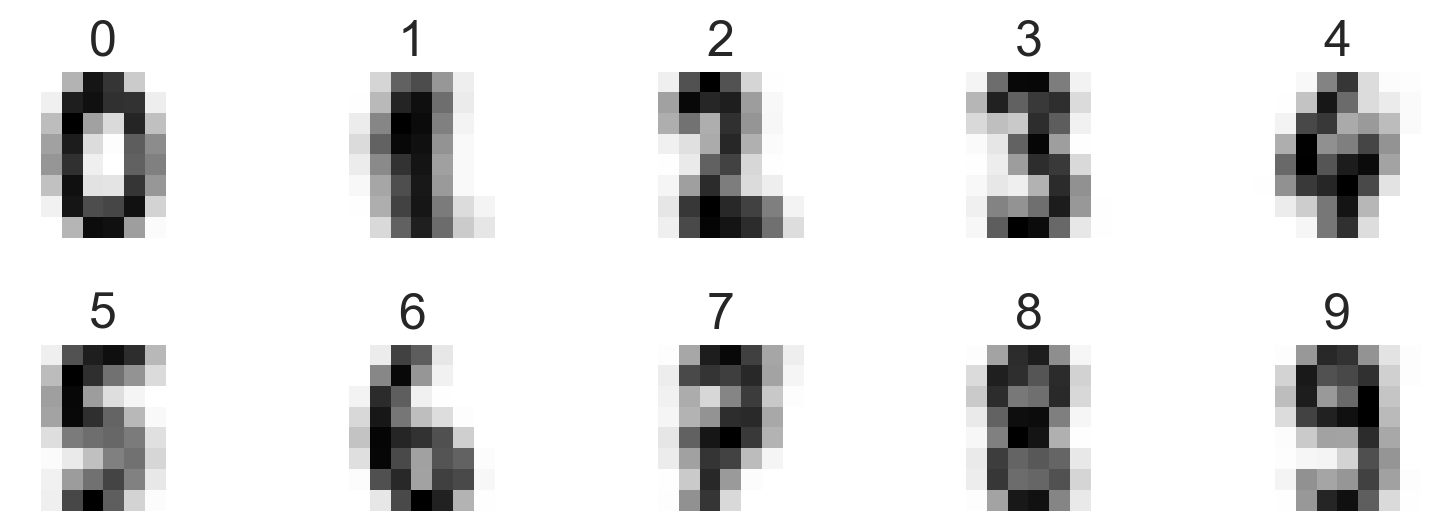

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for k, ax in enumerate(axes.flat):
    idx = y == k 
    X_k_mean = X[idx].mean(axis=0) 
    ax.imshow(X_k_mean.reshape((8, 8)), cmap='gray_r')
    ax.set(title=k, xticks=[], yticks=[])
sns.despine(bottom=True, left=True)
fig.tight_layout()

### KNN classifier
Let's split the data and train a KNN classifier.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [11]:
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
print("Test accuracy: {:.4f}".format(classifier.score(X_test, y_test)))

Test accuracy: 0.9764


## Confusion matrix

We can use [yellowbrick](https://www.scikit-yb.org/) to plot a [confusion matrix](https://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html) to understand where the confusion is: which classes are mistaken for which?

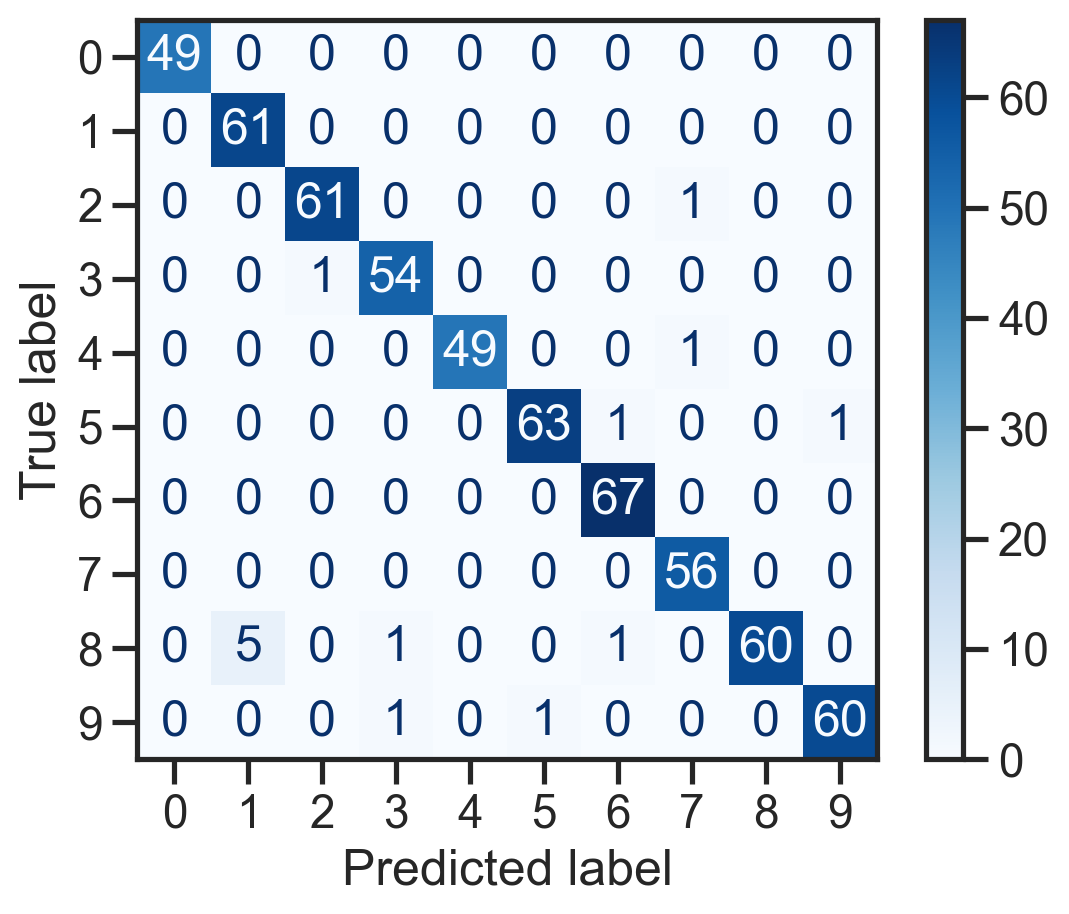

In [12]:
ConfusionMatrixDisplay.from_estimator(
    classifier,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
);

We can see that the most common mistake is that 8 are classified as 1, or sometimes 3.

# Logistic regression

Can we do any better with a different classifier?
Let's try the logistic regression classifer.
In this model, we try to estimate the probability $p_k$ that a data sample (image) belongs to class $k$ (digit $k$):
$$
p_k = \frac{1}{1+e^{-z_k}} $$$$
z_k = a_{1,k} x_1 + \ldots + a_{m,k} x_m
$$
where $x_j$ is pixel $j$ and $a_{j,k}$ is the increase in favor of class $k$ when pixel $j$ is dark.

In this case the loss function we minimize is *not* the sum of residual squares, but rather the **cross-entropy**:
$$
loss(p, y) = \sum_{i=1}^{n}{\sum_{k=0}^{9}{y_{i,k} \log{p_{i,k}}}}
$$
where $i$ is the image index ($n$ images overall), $k$ is the digit (i.e. class), $y_{i,k}=1$ if image $i$ is of digit $k$ and $y_{i,k}=0$ otherwise, and $p_{i,k}$ is the model prediction about the probability that image $i$ is of digit $k$.

In [13]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
print("Test accuracy: {:.4f}".format(logistic.score(X_test, y_test)))

Test accuracy: 0.9596


## How does it work?

The figure below plots the values of the coefficeints $a_{j,k}$: for each digit $k$, there is one plot that shows the effect of each pixel. 

For example, in the top left plot pixels shown in red decrease the probability for a 0 class when dark, and pixels in blue increase the probability for a 0 class when dark.

(10, 64)


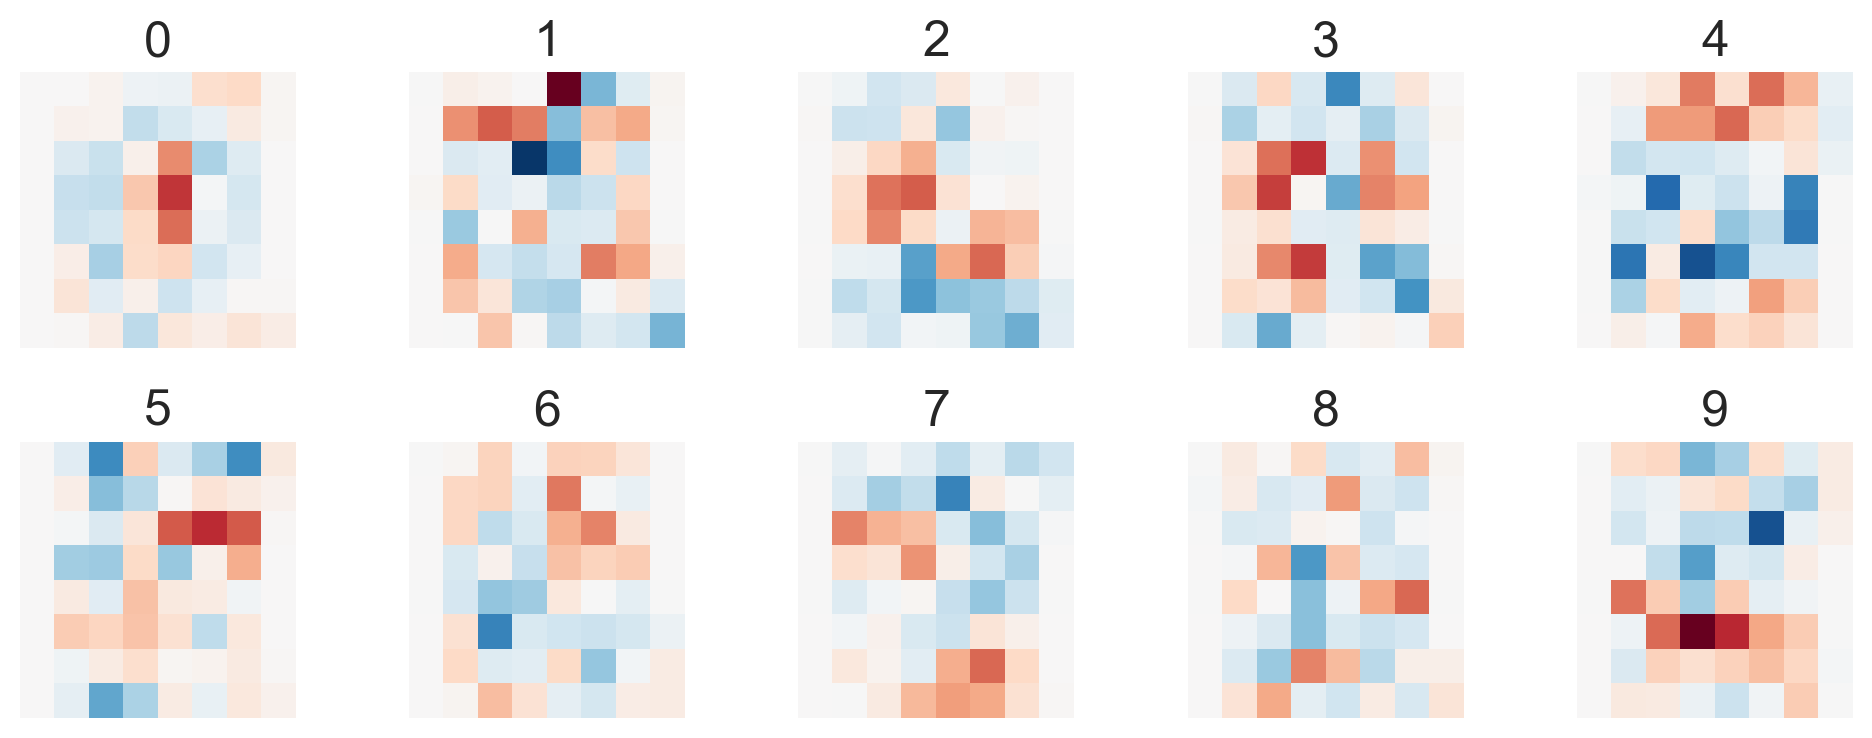

In [14]:
a = logistic.coef_
print(a.shape)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for k, ax in enumerate(axes.flat):
    ax.imshow(a[k, :].reshape((8, 8)), cmap='RdBu', vmin=-0.6, vmax=0.6)
    ax.set(title=k, xticks=[], yticks=[])
sns.despine(bottom=True, left=True)
fig.tight_layout()

# Vehicle detection dataset

We now load a dataset of vehicle detection.

In [108]:
df = pd.read_parquet('../data/vehicle_detection.parquet')
df.head()
df.drop(columns=['clip_name'])

,frame_id,vehicle_type,detection,distance,label_weather,label_lightingcondition
0,0,car,False,24,Clear,Night
1,1,car,True,75,Clear,Night
2,2,car,True,49,Clear,Night
3,3,car,True,12,Clear,Night
4,4,car,False,61,Clear,Night
...,...,...,...,...,...,...
499995,293,truck,True,86,Clear,Day
499996,294,truck,True,2,Clear,Day
499997,295,truck,True,76,Clear,Day
499998,296,truck,False,94,Clear,Day


In [ ]:
df.to_parquet

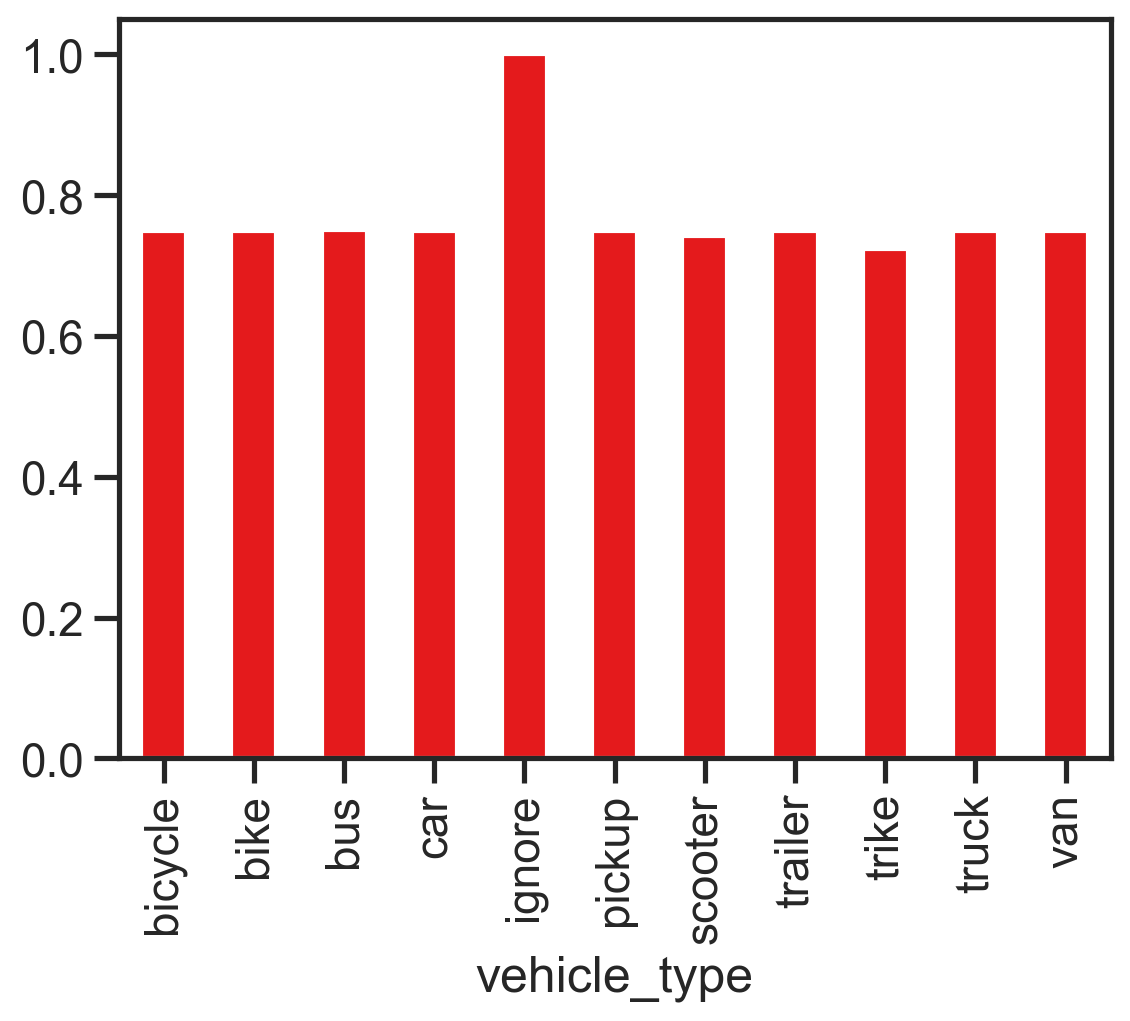

In [3]:
df.groupby('vehicle_type')['detection'].mean().plot.bar();

Let's check it with a logistic regression - we will see if it's easier to predict detection using the vehicle type.

## Preprocess data for logistic regression

These are the vechile types:

In [4]:
print(df['vehicle_type'].unique())

['car', 'truck', 'van', 'bicycle', 'trailer', ..., 'bike', 'bus', 'scooter', 'ignore', 'trike']
Length: 11
Categories (11, object): ['bicycle', 'bike', 'bus', 'car', ..., 'trailer', 'trike', 'truck', 'van']


Let's remove the `ignore` type.

In [5]:
df = df[df['vehicle_type'] != 'ignore'].copy()

Now we wish to encode the vehicle types, weather labels, and lighting labels for regression as one-hot encoded variables corrseponding to a boolean for each type, but then convert the boolean to integer.

In [23]:
vehicle_type_1hot = pd.get_dummies(df['vehicle_type'], dtype=int)
vehicle_type_1hot.head()

,bicycle,bike,bus,car,ignore,pickup,scooter,trailer,trike,truck,van
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [24]:
label_weather_1hot = pd.get_dummies(df['label_weather'], dtype=int)
label_weather_1hot.head()

,Clear,Cloudy,Heavy_Rain,Overcast
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [25]:
label_lightingcondition_1hot = pd.get_dummies(df['label_lightingcondition'], dtype=int)
label_lightingcondition_1hot.head()

,Day,Dusk,Night
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [37]:
df = pd.concat([df, vehicle_type_1hot, label_weather_1hot, label_lightingcondition_1hot], axis=1)
df.head()

,clip_name,frame_id,vehicle_type,detection,distance,label_weather,label_lightingcondition,bicycle,bike,bus,...,trike,truck,van,Clear,Cloudy,Heavy_Rain,Overcast,Day,Dusk,Night
0,PNT1_Nlsn_210107_152450_0000_s001_v_AllCams_s6...,0,car,0,24,Clear,Night,False,False,False,...,0,0,0,1,0,0,0,0,0,1
1,PNT1_Nlsn_210107_152450_0000_s001_v_AllCams_s6...,1,car,1,75,Clear,Night,False,False,False,...,0,0,0,1,0,0,0,0,0,1
2,PNT1_Nlsn_210107_152450_0000_s001_v_AllCams_s6...,2,car,1,49,Clear,Night,False,False,False,...,0,0,0,1,0,0,0,0,0,1
3,PNT1_Nlsn_210107_152450_0000_s001_v_AllCams_s6...,3,car,1,12,Clear,Night,False,False,False,...,0,0,0,1,0,0,0,0,0,1
4,PNT1_Nlsn_210107_152450_0000_s001_v_AllCams_s6...,4,car,0,61,Clear,Night,False,False,False,...,0,0,0,1,0,0,0,0,0,1


Lastly, we convert the detection column to integers.

In [27]:
df['detection'] = df['detection'].astype(int)

## Logistic regression

As a baseline we classify using `distance` as the sole independent variable.

In [93]:
features = ['distance']
X = df[features]
y = df['detection']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [101]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print("Accuracy: {:.4f} (% true: {:.4f})".format(classifier.score(X_test, y_test), y.mean()))

Accuracy: 0.7489 (% true: 0.7495)


Now let's try with the vechile types as additional independent variables.

In [102]:
features = np.append(vehicle_type_1hot.columns, 'distance')
X = df[features]
y = df['detection']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [103]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.749552

Classification accuracy is almost identical with or without vehicle type as a predictor, so we can rule out that this is an important factor for predicting detection.

What if we add lighting and weather?

In [104]:
features = np.concat([label_weather_1hot.columns, label_lightingcondition_1hot.columns, vehicle_type_1hot.columns, ['distance']])
X = df[features]
y = df['detection']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [106]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.749408

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)